In [2]:
using Plots
using Distributions
using PGFPlotsX
using DifferentialEquations
using MutableNamedTuples
using Parameters

# 1. Define constants, probability distribution, and the prob function  #

In [3]:
#first, map out normal distributions for the molecular velocities and randomly sample from them.

@consts begin
    hbar = 1.054e-34 #planck constant, J.s
    lambda = 687e-9 #mainline wavelength, nm
    k_number = 2π/lambda #wavevector, 1/nm
    scatter_rate = 1e6 #mainline scattering rate, MHZ
    cap_velocity = 10.0 #SrOH MOT capture velocity, m/s
    kB = 1.38e-23 #boltzmann constant, J/K
    amu = 1.66e-27 #atomic mass unit
    m = amu*104 #mass of SrOH
    MOT_radius = 0.0127 #m
    slowing_focus = 0.005 #m
    slowing_distance = 1.5 + 0.01 #m
    cell_to_4K = 0.2 #m 
    diameter_4K = 0.015 #m
    cell_to_40K = 0.22 #m 
    diameter_40K = 0.0254 #m
    cell_to_UHV = 0.3 #m
    diameter_UHV = 0.0254 #m
    T1 = 20.0 #forward "temperature" of beam, to match the experimentally measured velocity profile, K
    delta_v_transverse = 2.0*tan(22.5/2.0*(pi/180.0))*100.0/2.355 
end

#the transverse temperature is selected such that the FWHM angular width of the beam is around 60 degrees
#using tan(\theta/2) = (delta v_transverse/2)/v_longitudinal, where delta v_transverse is the FWHM of the tranverse velocity dist
delta_v_transverse = 2.0*tan(22.5/2.0*(pi/180.0))*100.0/2.355 

#vy and vz are the transverse velocities, vx is the longitudinal. below we construct the normal velocity distributions
#T1 is picked so that the forward velocity distribution matches the experiment
vx_dist = Normal(100.0, sqrt(kB*T1/2m))
vz_dist = Normal(0, delta_v_transverse)
vy_dist = Normal(0, delta_v_transverse)
y_dist = Uniform(-0.0035, 0.0035)
z_dist = Uniform(-0.0035, 0.0035)
;

In [4]:
#Define prob-function used to update the diff eq solver for each molecular trajectory

B1 = 1.0 #Bfield of first guide, T
muB = 9.27e-24 #bohr magneton
Umax = B1*muB #max energy due to B field, J
B1_radius = 0.0127 #lens inner radius, m
B2_r_max = 1*0.0127
B2_r_min = 0.5*0.0127
B2_rem = 1.5 #T
B2_thickness = B2_r_max - B2_r_min
w = sqrt(2*Umax/(m*B1_radius^2)) #oscillation frequency
k = w^2*m #spring constant
B1_end = 0.44 #end of first magnet, m
B1_start = 0.4 #start of first magnet, m
B2_start = 0.6 #start of second magnet, m
B2_end = 0.65 #end of second magnet, m
B2_length = B2_end - B2_start
B2_coefficient = 3*muB*B2_rem/m;
lens = true #turn lens on, m
telescope = true #turn telescope on
transverse = true #turn transverse cooling on
slowing = true #turn slowing on 

#define the prob function to update while the diffeq solver runs
p = MutableNamedTuple(
    vx_dist = vx_dist,
    vy_dist = vy_dist,
    vz_dist = vz_dist,
    z_dist = z_dist,
    y_dist = y_dist,
    B1_end = B1_end,
    B1_start = B1_start,
    B1_radius = B1_radius,
    B2_start = B2_start,
    B2_end = B2_end,
    B2_length = B2_length,
    B2_rem = B2_rem,
    B2_r_min = B2_r_min,
    B2_r_max = B2_r_max,
    B2_coefficient = B2_coefficient,
    B2_thickness = B2_thickness,
    lens = lens,
    transverse = transverse,
    telescope = telescope,
    slowing = slowing,
    k=k,
    w=w
    );

# 2. Applying the decelerations at the relevant positions, setting conditions to terminate molecules that will never be trapped #

In [5]:
#Simulating trajectories for multiple particles using diff-eqs
# u[1] = x
# u[2] = y
# u[3] = z
# u[4] = vx
# u[5] = vy
# u[6] = vz

function Ri(x)
    return p.B2_r_max - (x - p.B2_start)*(p.B2_r_max - p.B2_r_min)/(p.B2_length)
end

function f(du, u, p, t)
    
    du[1] = u[4]
    du[2] = u[5]
    du[3] = u[6]
    
    if (u[1] > p.B1_start + 0.001 #apply a harmonic force to molecules that enter the first lens
            && u[1] < p.B1_end - 0.001
            && p.lens)
        
        du[5] = -(p.k/m)*u[2]
        du[6] = -(p.k/m)*u[3]
        
    elseif (u[1] > p.B1_end + 0.001 #apply transverse cooling after lens
            && u[1] < p.B1_end + 0.005
            && abs(u[5]) <= 1.0 
            && abs(u[6]) <= 1.0 
            && p.transverse)
        
        u[5] = 0.
        u[6] = 0.

    elseif (u[1] > 0 #if no lensing or transverse, apply slowing only
            && u[1] < slowing_distance + 0.01 
            && ~p.lens 
            && p.slowing 
            && u[2]^2+u[3]^2 < (((MOT_radius - slowing_focus)/slowing_distance)*(u[1]) + slowing_focus)^2)
        
        du[4] = -hbar*k_number*scatter_rate/m
        du[5] = 0.
        du[6] = 0.
            
    elseif (u[1] > p.B2_start - 0.001
            && u[1] < p.B2_end + 0.001
            && u[2]^2 + u[3]^2 < Ri(u[1])^2
            && p.telescope )

        du[4] = 0.
        du[5] = -u[2] * p.B2_coefficient * p.B2_thickness^2 * 1/((Ri(u[1])^2) * (Ri(u[1])^2 + p.B2_thickness^2))
        du[6] = -u[3] * p.B2_coefficient * p.B2_thickness^2 * 1/((Ri(u[1])^2) * (Ri(u[1])^2 + p.B2_thickness^2))    
   
    elseif (u[1] > p.B2_end #slow molecules that see the cone of the slowing light, the slowing light is about 7mm in diameter at the end of the magnet    
            && p.slowing 
            && p.transverse
            && p.lens
            && u[2]^2+u[3]^2 < ((((MOT_radius - slowing_focus)/slowing_distance)*(u[1]-p.B2_end)) + slowing_focus)^2)
        
        du[4] = -hbar*k_number*scatter_rate/m
        du[5] = 0.
        du[6] = 0.
        
    else
        du[4] = 0.
        du[5] = 0.
        du[6] = 0.
        
    end
    return nothing
end
;

In [33]:
#set initial conditions, only for one trajectory at this point

condition1(u, t, integrator) = u[1] - integrator.p.B2_end - slowing_distance < 0.001

function condition2(u, t, integrator) #stop trajectories if molecules don't enter first magnet
    (u[1] > integrator.p.B1_start - 0.001 
        && u[1] < integrator.p.B1_start + 0.001 
        && u[2]^2 + u[3]^2 > integrator.p.B1_radius^2)
end

function condition3(u, t, integrator) #terminate trajectories if molecules hit the magnet walls
    (u[1] > integrator.p.B1_start - 0.001 
        && p.lens
        && u[1] < integrator.p.B1_start + 0.001 
        && u[2]^2 + u[3]^2 > integrator.p.B1_radius^2)
end

function condition4(u, t, integrator) #terminate molecules that hit 4K shield
    (u[1] > cell_to_4K - 0.001 
        && u[1] < cell_to_4K + 0.001 
        && u[2]^2 + u[3]^2 > (diameter_4K/2)^2)
end

function condition5(u, t, integrator) #terminate molecules that hit 40K shield
    (u[1] > cell_to_40K - 0.001 
        && u[1] < cell_to_40K + 0.001 
        && u[2]^2 + u[3]^2 > (diameter_40K/2)^2)
end

function condition6(u, t, integrator) #terminate molecules that hit UHV shutter
    (u[1] > cell_to_UHV - 0.001 
        && u[1] < cell_to_UHV + 0.001 
        && u[2]^2 + u[3]^2 > (diameter_UHV/2)^2)
end

function condition7(u, t, integrator) #terminate molecules that dont start in the slowing light
    (u[1] > - 0.001 
        && u[1] <  0.001 
        && u[2]^2 + u[3]^2 > slowing_focus^2)
end

condition8(u, t, integrator) = u[1] - slowing_distance < 0.001 #(no lens)

function condition9(u,t, integrator) #terminate molecules that hit the walls of the telescope
    (u[1] > integrator.p.B2_start - 0.001 
    && p.lens
    && u[1] < integrator.p.B2_end + 0.001 
    && u[2]^2 + u[3]^2 > Ri(u[1])^2)
end

function condition10(u,t, integrator)
    (u[1] > integrator.p.B1_end + 0.003
    && p.lens
    && u[1] < integrator.p.B1_end + 0.008
    && u[5] != 0
    && u[6] != 0 )
end
    
function affect1!(integrator)
   terminate!(integrator)
end

cb1 = ContinuousCallback(condition1, affect1!)
cb2 = DiscreteCallback(condition2, affect1!)
cb3 = DiscreteCallback(condition3, affect1!)
cb4 = DiscreteCallback(condition4, affect1!)
cb5 = DiscreteCallback(condition5, affect1!)
cb6 = DiscreteCallback(condition6, affect1!)
cb7 = DiscreteCallback(condition7, affect1!)
cb8 = ContinuousCallback(condition8, affect1!)
cb9 = ContinuousCallback(condition9, affect1!)
cb10 = ContinuousCallback(condition10, affect1!)

tspan = (0.0, 0.3)#set the timespan for the solver
u0 = [0.,0.,0.,0.,0.,0.]

callback_set_lens = CallbackSet(cb1, cb2, cb3, cb4, cb5, cb6, cb9, cb10)#create a set of the callbacks
callback_set_only_slowing = CallbackSet(cb4, cb5, cb6, cb8)

@time prob_lens = ODEProblem(f, u0, tspan, p; alg=Tsit5(), dtmax = 1e-5, saveat = 1e-3, callback = callback_set_lens)#define the problem
# # @time prob_slowing = ODEProblem(f, u0, tspan, p; alg=Tsit5(), dtmax = 1e-5, saveat = 1e-2, callback = callback_set_only_slowing)#define the problem

# #@time prob_lens = ODEProblem(f, u0, tspan, p; alg=Tsit5(), dtmax = 1e-5, save_at = 1e-3, callback = callback_set_lens)#define the problem
@time prob_slowing = ODEProblem(f, u0, tspan, p; alg=Tsit5(), dtmax = 1e-5, save_everystep=false, callback = callback_set_only_slowing)#define the problem
;

  0.000097 seconds (68 allocations: 3.828 KiB)
  0.000096 seconds (68 allocations: 3.281 KiB)


In [327]:
# Condition 1: Stop trajectories if molecules don't enter first magnet
function cond1(u, t, integrator)
    return integrator.p.B1_start - u[1]
end 
function cond1_affect!(integrator)
    integrator.dtpropose = 1e-6
    if integrator.u[2]^2 + integrator.u[3]^2 > integrator.p.B1_radius^2
        terminate!(integrator)
    end
end

# Condition 2: Stop trajectories if molecules hit the 4K shield
function cond2(u, t, integrator)
    return cell_to_4K - u[1]
end
function cond2_affect!(integrator)
    if integrator.u[2]^2 + integrator.u[3]^2 > (diameter_4K/2)^2
        terminate!(integrator)
    end
end

# Condition 3: Stop molecules after they have travelled the full slowing distance
function cond3(u, t, integrator)
    return u[1] - integrator.p.B2_end - slowing_distance
end
function cond3_affect!(integrator)
    terminate!(integrator)
end

# Condition 4: Stop molecules that hit the walls of the telescope
function cond4(u, t, integrator)
    return u[1] - integrator.p.B2_end
end
function cond4_affect!(integrator)
    integrator.dtpropose = 1e-6
    if integrator.u[2]^2 + integrator.u[3]^2 > Ri(integrator.u[1])^2
        terminate!(integrator)
    end
end

# Condition 5: Stop any trajectory outside a 2 cm radius
function cond5(u, t, integrator)
    return integrator.u[2]^2 + integrator.u[3]^2 > 0.02^2
end
function cond5_affect!(integrator)
    terminate!(integrator)
end


cb1 = ContinuousCallback(cond1, cond1_affect!)
cb2 = ContinuousCallback(cond2, cond2_affect!)
cb3 = ContinuousCallback(cond3, cond3_affect!)
cb4 = ContinuousCallback(cond4, cond4_affect!)
cb4 = ContinuousCallback(cond5, cond5_affect!)

tspan = (0.0, 0.3) # set the timespan for the solver
u0 = [0.,0.,0.,0.,0.,0.]

callback_set_lens = CallbackSet(cb1, cb2, cb3, cb4, cb5)
callback_set_only_slowing = CallbackSet(cb4, cb5, cb6, cb8)

u0[1] = 0.002
u0[2] = 0.002
u0[4] = 100.
u0[5] = 0.3
@time prob_lens = ODEProblem(f, u0, tspan, p; alg=DP5(), saveat=1e-3, callback = callback_set_lens) #define the problem
@time prob_slowing = ODEProblem(f, u0, tspan, p; alg=DP5(), callback = callback_set_only_slowing) #define the problem
;

  0.055580 seconds (48.45 k allocations: 3.248 MiB, 98.57% compilation time)
  0.041837 seconds (76.74 k allocations: 5.336 MiB, 98.47% compilation time)


In [328]:
integrator.dtpropose

1.4072221109095919e-5

# 3. Solving for a single molecule trajectory to make sure code runs and benchmark the efficiency

In [329]:
# #create a vector for each parameter
x(k) = k[1]
y(k) = k[2]
z(k) = k[3]
vx(k) = k[4]
vy(k) = k[5]
vz(k) = k[6]
r1(k) = (k[1], k[2])
r2(k) = (k[1], k[3])
r3(k) = (k[1], k[2], k[3])
;

In [330]:
@time sol = solve(prob_lens)#solve the ODE
;

  8.604832 seconds (11.95 M allocations: 784.295 MiB, 9.96% gc time, 100.00% compilation time)


In [331]:
sol.u

305-element Vector{Vector{Float64}}:
 [0.002, 0.002, 0.0, 100.0, 0.3, 0.0]
 [0.10200000000000002, 0.0023, 0.0, 100.0, 0.3, 0.0]
 [0.19999999999999998, 0.002594, 0.0, 100.0, 0.3, 0.0]
 [0.19999999999999998, 0.002594, 0.0, 100.0, 0.3, 0.0]
 [0.20199999999999999, 0.0026, 0.0, 100.0, 0.3, 0.0]
 [0.302, 0.0029, 0.0, 100.0, 0.3, 0.0]
 [0.3999999999999999, 0.0031950025844395148, 0.0, 99.41970156268691, 0.3, 0.0]
 [0.3999999999999999, 0.0031950025844395148, 0.0, 99.41970156268691, 0.3, 0.0]
 [0.4016561385453605, 0.0031999501291219814, 0.0, 99.41970156268691, 0.28515932833550117, 0.0]
 [0.501077900692328, 0.0027777854183009686, 0.0, 99.427150426537, -0.6176038952281853, 0.0]
 [0.6007993083586073, 0.0021601815230727836, 0.0, 99.81883634912599, -0.6176038952281853, 0.0]
 [0.6991971325845341, 0.001542577627844598, 0.0, 96.47605096523898, -0.6176038952281853, 0.0]
 [0.7928955840667823, 0.0009249737326164131, 0.0, 90.63361647868707, -0.6176038952281853, 0.0]
 ⋮
 [0.6397767061734275, -0.1726217208265

In [332]:
#now, moving onto doing this for many molecules
#define a prob function, where the ODE solver is run for each updated paramter
function prob_func(prob, i, repeat)
    prob.u0[2] = rand(prob.p.y_dist)
    prob.u0[3] = rand(prob.p.z_dist)
    prob.u0[4] = rand(prob.p.vx_dist)
    prob.u0[5] = rand(prob.p.vy_dist)
    prob.u0[6] = rand(prob.p.vz_dist)
    return prob
end
;

# 4. Apply the solver to an ensemble of molecules, only slowing with no lensing

In [333]:
n_molecules = 100
ensemble_prob_slowing = EnsembleProblem(prob_slowing; prob_func=prob_func)#using the prob and prob function, solve for multiple trajectories
;

In [334]:
#set up a function to return true if a molecule is trapped
#the conditions 1) the molecule has vx below cap velocity
#2) the molecules are within the confines of the MOT
#3) the molecules have traveled the correct distance

function trapped(sol)
    if (x(sol.u[end]) > slowing_distance 
    && y(sol.u[end])^2 + z(sol.u[end])^2 < MOT_radius^2
    && 0 < vx(sol.u[end]) < 10)
        return true
    else 
        return false
    end
end 

trapped (generic function with 1 method)

In [335]:
ensemble_prob_slowing.prob.p.slowing = true
ensemble_prob_slowing.prob.p.transverse = false
ensemble_prob_slowing.prob.p.lens = false
batches = 1

trapped_molecules = []

for i in 1:batches
    @time ensemble_sol_slowing = solve(ensemble_prob_slowing, EnsembleThreads(); trajectories = n_molecules)
    for sol in ensemble_sol_slowing
        if trapped(sol) 
            push!(trapped_molecules, sol)
        end
    end
end
;

  5.515885 seconds (10.76 M allocations: 718.728 MiB, 3.11% gc time, 99.91% compilation time)


In [336]:
println("The number of molecules trapped when only slowing is applied is ", length(trapped_molecules), " out of ", n_molecules*batches, ".")

The number of molecules trapped when only slowing is applied is 0 out of 100.


# 5. Apply the problem to a configuration with a lens and telescope to visualize via plotting

In [320]:
n_molecules = 1000
ensemble_prob_lensing = EnsembleProblem(prob_lens; prob_func=prob_func)#using the prob and prob function, solve for multiple trajectories
ensemble_prob_lensing.prob.p.B2_start = 0.6
ensemble_prob_lensing.prob.p.B2_end = 0.64
ensemble_prob_lensing.prob.p.B2_r_max = 1.5*0.0127
ensemble_prob_lensing.prob.p.B2_r_min = 1*0.0127
ensemble_prob_lensing.prob.p.B2_length = ensemble_prob_lensing.prob.p.B2_end - ensemble_prob_lensing.prob.p.B2_start
ensemble_prob_lensing.prob.p.slowing = true
ensemble_prob_lensing.prob.p.transverse = true
ensemble_prob_lensing.prob.p.lens = true
ensemble_prob_lensing.prob.p.telescope = true
;

In [325]:
@time ensemble_sol_lensing = solve(ensemble_prob_lensing, EnsembleThreads(); trajectories = n_molecules)
;

  4.828248 seconds (2.20 M allocations: 281.969 MiB, 3.71% gc time, 0.00% compilation time)


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\tey0W\src\integrator_interface.jl:586


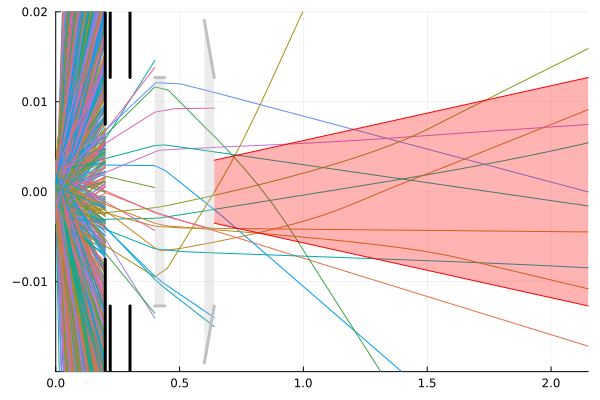

In [326]:
plot()
plot!.(r1.(ensemble_sol_lensing[i].u) for i ∈ 1:n_molecules)
plot!(legend=nothing)
Inner_radii = [Ri(i) for i in range(B2_start, stop = B2_end, step = 0.01)]

plot!([cell_to_4K, cell_to_4K],[diameter_4K/2, 10], linewidth = 3, color = "black")
plot!([cell_to_4K, cell_to_4K],[-diameter_4K/2, -10], linewidth = 3, color = "black")

plot!([cell_to_40K, cell_to_40K],[diameter_40K/2, 10], linewidth = 3, color = "black")
plot!([cell_to_40K, cell_to_40K],[-diameter_40K/2, -10], linewidth = 3, color = "black")

plot!([cell_to_UHV, cell_to_UHV],[diameter_UHV/2, 10], linewidth = 3, color = "black")
plot!([cell_to_UHV, cell_to_UHV],[-diameter_UHV/2, -10], linewidth = 3, color = "black")

plot!([B1_start, B1_end],[B1_radius, B1_radius], linewidth = 3, fill = true, color = "silver", fillalpha = 0.3)
plot!([B1_start, B1_end],[-B1_radius, -B1_radius], linewidth = 3, fill = true, color = "silver", fillalpha = 0.3)

plot!([B2_end, slowing_distance+B2_end],[0.0035, MOT_radius], fill = true, color = "red", linewidth = 1, fillalpha = 0.3)
plot!([B2_end, slowing_distance+B2_end],[-0.0035, -MOT_radius], fill = true, color = "red", linewidth = 1, fillalpha = 0.3)
x_vals = range(B2_start, B2_end, length = 20)

plot!(x_vals, Ri.(x_vals), linewidth = 3, fill = true, color = "silver", fillalpha = 0.3)
plot!(x_vals, -Ri.(x_vals), linewidth = 3, fill = true, color = "silver", fillalpha = 0.3)

xlims!(0.0, B2_end + slowing_distance)
ylims!(-0.02, 0.02)

# 6. Varying Telescope Length

In [261]:
B2_ends = range(0.6, stop = 0.7, step = 0.01)
ensemble_sols_B2end = []
n2_molecules = 10000
prob_lens.p.slowing = false
prob_lens.p.transverse = true
prob_lens.p.telescope = true
prob_lens.p.lens = true

@time for B2_end in B2_ends
    ensemble_prob_lensing.prob.p.B2_start = 0.6
    ensemble_prob_lensing.prob.p.B2_r_max = 1.5*0.0127
    ensemble_prob_lensing.prob.p.B2_r_min = 1*0.0127
    prob_lens.p.B2_end = B2_end
    ensemble_prob_lensing.prob.p.B2_length = ensemble_prob_lensing.prob.p.B2_end - ensemble_prob_lensing.prob.p.B2_start    
    ensemble_prob_B2end = EnsembleProblem(prob_lens; prob_func=prob_func)
    ensemble_sol_B2end = solve(ensemble_prob_B2end, trajectories=n2_molecules)
    push!(ensemble_sols_B2end, ensemble_sol_B2end)
end
;

119.757653 seconds (539.71 M allocations: 39.811 GiB, 66.74% gc time)


In [262]:
filtered_y = []
filtered_z = []
filtered_x = []


#filter the trajectories by molecules that actually made it into the lense
for i in 1:length(B2_ends)
    push!(filtered_y, [y.(ensemble_sols_B2end[i][j].u) for j in 1:n2_molecules if last(x.(ensemble_sols_B2end[i][j].u)) > B2_ends[i]+0.1])
    push!(filtered_z, [z.(ensemble_sols_B2end[i][j].u) for j in 1:n2_molecules if last(x.(ensemble_sols_B2end[i][j].u)) > B2_ends[i]+0.1])
    push!(filtered_x, [x.(ensemble_sols_B2end[i][j].u) for j in 1:n2_molecules if last(x.(ensemble_sols_B2end[i][j].u)) > B2_ends[i]+0.1])
end

y_vals_last = []
z_vals_last = []

for i in 1:length(B2_ends)
    push!(y_vals_last, [last(filtered_y[i][j]) for j in 1:length(filtered_y[i])])
    push!(z_vals_last, [last(filtered_z[i][j]) for j in 1:length(filtered_z[i])])
end

y_vals_first = []
z_vals_first = []

for i in 1:length(B2_ends)
     push!(y_vals_first, [filtered_y[i][j][findfirst(x -> x > B2_ends[i],  filtered_x[i][j])] for j in 1:length(filtered_y[i])])
     push!(z_vals_first, [filtered_z[i][j][findfirst(x -> x > B2_ends[i],  filtered_x[i][j])] for j in 1:length(filtered_z[i])])
end

RMS_y_MOT = [] #at MOT region
RMS_z_MOT = [] #at MOT region

for i in 1:length(B2_ends)
    push!(RMS_y_MOT, sqrt(sum(y_vals_last[i].^2)/length(y_vals_last[i])))
    push!(RMS_z_MOT, sqrt(sum(z_vals_last[i].^2)/length(z_vals_last[i])))
end

RMS_total_MOT = sqrt.(RMS_y_MOT.^2 + RMS_z_MOT.^2)

RMS_y_first = [] #at MOT region
RMS_z_first = [] #at MOT region

for i in 1:length(B2_ends)
    push!(RMS_y_first, sqrt(sum(y_vals_first[i].^2)/length(y_vals_first[i])))
    push!(RMS_z_first, sqrt(sum(z_vals_first[i].^2)/length(z_vals_first[i])))
end

RMS_total_MOT = sqrt.(RMS_y_MOT.^2 + RMS_z_MOT.^2)
RMS_total_first = sqrt.(RMS_y_first.^2 + RMS_z_first.^2)



11-element Vector{Float64}:
 0.008422057894227697
 0.008202441092182178
 0.008107372935653846
 0.008180896957621796
 0.008206980830292516
 0.00808617493347032
 0.007963194243366714
 0.007589776620651695
 0.008135823598680472
 0.007468697858227539
 0.007133420392326067

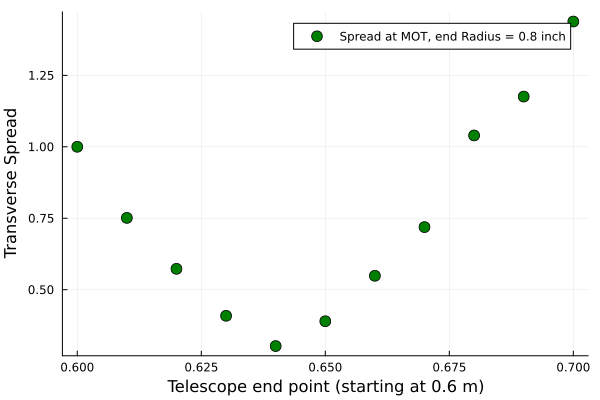

In [263]:
plot()
plot!(B2_ends, RMS_total_MOT./RMS_total_first, seriestype = :scatter, label = "Spread at MOT, end Radius = 0.8 inch", color = "green", markersize = 6, legend=:topright)
#plot!(B2_ends, RMS_total_first, seriestype = :scatter, label = "Spread after Magnet", color = "green", markersize = 6)
xlabel!("Telescope end point (starting at 0.6 m)")
ylabel!("Transverse Spread")


# 7. Varying Telescope End Radius

In [258]:
B2_r_mins = range(0.002, stop = 0.014, step = 0.001)
ensemble_sols_B2_r_mins = []
n2_molecules = 10000
prob_lens.p.slowing = false
prob_lens.p.transverse = true
prob_lens.p.telescope = true
prob_lens.p.lens = true

@time for B2_r_min in B2_r_mins
    ensemble_prob_lensing.prob.p.B2_start = 0.6
    ensemble_prob_lensing.prob.p.B2_r_max = 1.5*0.0127
    ensemble_prob_lensing.prob.p.B2_r_min = 1*0.0127
    prob_lens.p.B2_end = 0.63
    ensemble_prob_lensing.prob.p.B2_length = ensemble_prob_lensing.prob.p.B2_end - ensemble_prob_lensing.prob.p.B2_start    
    ensemble_prob_B2_r_mins = EnsembleProblem(prob_lens; prob_func=prob_func)
    ensemble_sol_B2_r_mins = solve(ensemble_prob_B2_r_mins, trajectories=n2_molecules)
    push!(ensemble_sols_B2_r_mins, ensemble_sol_B2_r_mins)
end
;

126.224135 seconds (613.70 M allocations: 46.148 GiB, 63.82% gc time)


In [259]:
filtered_y = []
filtered_z = []
filtered_x = []


#filter the trajectories by molecules that actually made it into the lense
for i in 1:length(B2_r_mins)
    push!(filtered_y, [y.(ensemble_sols_B2_r_mins[i][j].u) for j in 1:n2_molecules if last(x.(ensemble_sols_B2_r_mins[i][j].u)) > B2_r_mins[i]+0.1])
    push!(filtered_z, [z.(ensemble_sols_B2_r_mins[i][j].u) for j in 1:n2_molecules if last(x.(ensemble_sols_B2_r_mins[i][j].u)) > B2_r_mins[i]+0.1])
    push!(filtered_x, [x.(ensemble_sols_B2_r_mins[i][j].u) for j in 1:n2_molecules if last(x.(ensemble_sols_B2_r_mins[i][j].u)) > B2_r_mins[i]+0.1])
end

y_vals_last = []
z_vals_last = []

for i in 1:length(B2_r_mins)
    push!(y_vals_last, [last(filtered_y[i][j]) for j in 1:length(filtered_y[i])])
    push!(z_vals_last, [last(filtered_z[i][j]) for j in 1:length(filtered_z[i])])
end

y_vals_first = []
z_vals_first = []

for i in 1:length(B2_r_mins)
     push!(y_vals_first, [filtered_y[i][j][findfirst(x -> x > B2_r_mins[i],  filtered_x[i][j])] for j in 1:length(filtered_y[i])])
     push!(z_vals_first, [filtered_z[i][j][findfirst(x -> x > B2_r_mins[i],  filtered_x[i][j])] for j in 1:length(filtered_z[i])])
end

RMS_y_MOT = [] #at MOT region
RMS_z_MOT = [] #at MOT region

for i in 1:length(B2_r_mins)
    push!(RMS_y_MOT, sqrt(sum(y_vals_last[i].^2)/length(y_vals_last[i])))
    push!(RMS_z_MOT, sqrt(sum(z_vals_last[i].^2)/length(z_vals_last[i])))
end

RMS_total_MOT = sqrt.(RMS_y_MOT.^2 + RMS_z_MOT.^2)

RMS_y_first = [] #at MOT region
RMS_z_first = [] #at MOT region

for i in 1:length(B2_r_mins)
    push!(RMS_y_first, sqrt(sum(y_vals_first[i].^2)/length(y_vals_first[i])))
    push!(RMS_z_first, sqrt(sum(z_vals_first[i].^2)/length(z_vals_first[i])))
end

RMS_total_MOT = sqrt.(RMS_y_MOT.^2 + RMS_z_MOT.^2)
RMS_total_first = sqrt.(RMS_y_first.^2 + RMS_z_first.^2)


13-element Vector{Float64}:
 0.02393567032442144
 0.024215845165803287
 0.024045069407109293
 0.024071718207939154
 0.02408635935296278
 0.02422580945685067
 0.023895853934629483
 0.024084257243644387
 0.024865511249459297
 0.02405993982870054
 0.024114426101681685
 0.02429268223766277
 0.024261062671169318

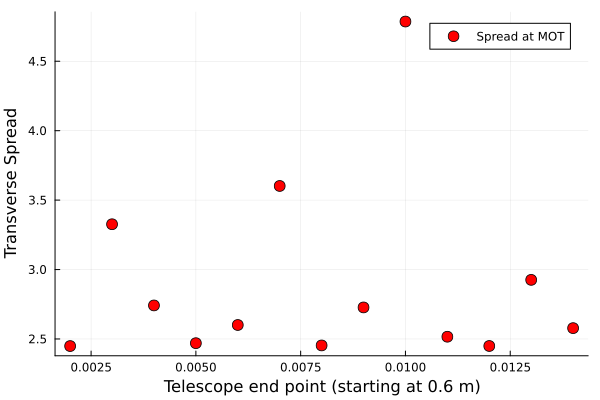

In [260]:
plot()
plot!(B2_r_mins, RMS_total_MOT./RMS_total_first, seriestype = :scatter, label = "Spread at MOT", color = "red", markersize = 6)
#plot!(B2_r_mins, RMS_total_first, seriestype = :scatter, label = "Spread after Magnet", color = "green", markersize = 6)
xlabel!("Telescope end point (starting at 0.6 m)")
ylabel!("Transverse Spread")
